In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tempForecast.components.data_transformation import WeatherDatabase
from tempForecast.components.data_ingestion import weather_scraping


from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import lightgbm as lgb


In [5]:
data = weather_scraping().load_data()
# on instancie la classe avec la base de donnée déjà chargé pour ne pas rescrapé tout
# si on met last_df en argument cela va scrapper seulement depuis la dernière date du df donc enlever pour éviter une interpolation
data_ingestion = weather_scraping(last_df=data)
# scraping 
data = data_ingestion.web_scraping()
# il faut ajouter cette base à la db
data_ingestion.load_data(df=data)
data = WeatherDatabase().load_data_and_transform()

2023-11-21 19:12:41.561018
https://www.infoclimat.fr/observations-meteo/archives/21/novembre/2023/paris-5eme-tour-zamansky-jussieu/000BV.html?dixminutes


c:\users\zbook create g7\desktop\temperature forecasting\src\tempForecast\components\data_ingestion.py:70: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  date_text = BeautifulSoup(


In [3]:
data.isna().sum()

id                       0
datetime                 0
température              6
vent                    27
rafales              15564
vent_direction       15564
humidite                 6
pt_de_rosee              6
pression                 0
bio_meteo            30392
radiation_solaire    52633
dtype: int64

In [16]:
data = data.drop(columns=['id','datetime'])
data.vent_direction = data.vent_direction.astype('float')
data.bio_meteo = data.bio_meteo.astype('float')

In [17]:
threshold_time = data.index.max() - pd.Timedelta(hours=168)

# Split the dataframe
df_train = data[data.index <= threshold_time]
df_last_week = data[data.index > threshold_time]

In [18]:
rf = lgb.LGBMRegressor()

In [19]:
X_train = df_train.drop(columns='température')
y_train = df_train['température']

X_test = df_last_week.drop(columns='température')
y_test = df_last_week['température']



In [21]:
rf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1103
[LightGBM] [Info] Number of data points in the train set: 59124, number of used features: 8
[LightGBM] [Info] Start training from score 13.472155


LGBMRegressor()

In [22]:
pred_train = rf.predict(X_train)
pred = rf.predict(X_test)

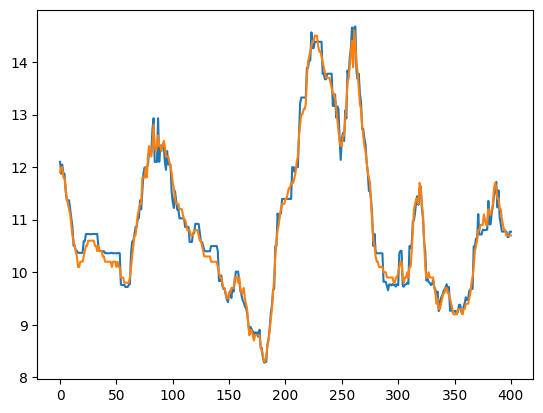

In [23]:
plt.plot(pred)
plt.plot(y_test.values)

In [24]:
mae = mean_absolute_error(y_test, pred)

In [25]:
mae

0.13439483222556847